# Postprocess the variational autoencoder results

In [1]:
EXPERIMENT_IDS = 'f1'
TIMEPOINTS = 'all'

In [2]:
OUT_DIR = '_'.join([EXPERIMENT_IDS, TIMEPOINTS, 'windows'])

## Imports

In [3]:
import sys
import os
from functools import partial

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import patac as pa
sc.settings.verbosity = 3

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sys.path.append('..')
from utils import settings
from utils import dataloader
from utils import scanpy_sugar

## Load processed anndata

In [7]:
adata = sc.read(os.path.join(settings.DATA_DIR, OUT_DIR, 'total_counts_vae.h5ad'))

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [8]:
adata

AnnData object with n_obs × n_vars = 35485 × 25000
    obs: 'exp_id', 'timepoint', 'n_genes', 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks', 'n_counts', 'X_pca_0', 'size_vae', 'time_vae'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count_variance'
    uns: 'exp_id_colors', 'neighbors', 'pca', 'timepoint_colors'
    obsm: 'X_pca', 'X_umap', 'X_vae'
    varm: 'PCs'
    layers: 'vae_peak_activities'
    obsp: 'distances', 'connectivities'

## Clustering & embedding

In [9]:
sc.pp.neighbors(adata, use_rep='X_vae')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)


2-D embedding with UMAP.

In [10]:
sc.tl.umap(adata, min_dist=0.1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:15)


Show embedding.

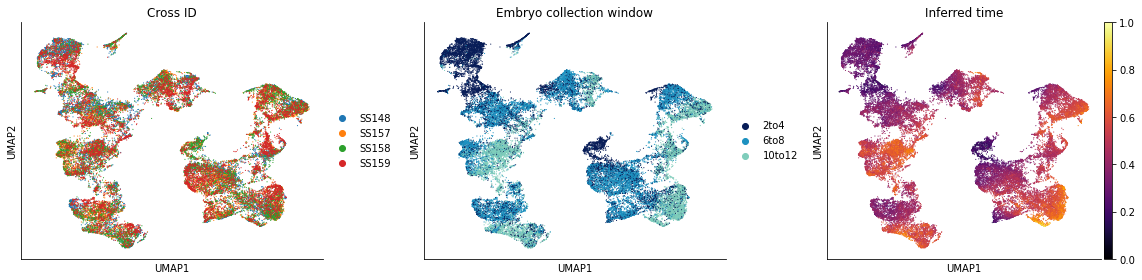

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sc.pl.umap(adata, color=['exp_id'], ax=axes[0], show=False, title='Cross ID', s=5)
sc.pl.umap(adata, color=['timepoint'], palette=['#081D58', '#1D91C0', '#7FCDBB'], ax=axes[1], show=False, title='Embryo collection window', s=5)
sc.pl.umap(adata, color=['time_vae'], ax=axes[2], show=False, title='Inferred time', s=5, cmap=plt.cm.inferno)
fig.tight_layout()

sns.despine()

In [12]:
sc.tl.leiden(adata, resolution=1.2, key_added='leiden_vae')

running Leiden clustering
    finished: found 28 clusters and added
    'leiden_vae', the cluster labels (adata.obs, categorical) (0:00:33)


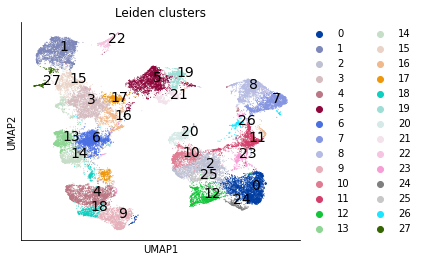

In [13]:
df_cluster_center = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index)
df_cluster_center['leiden_vae'] = adata.obs['leiden_vae']
df_cluster_center = df_cluster_center.groupby('leiden_vae').median()

fig, ax = plt.subplots(figsize=(5, 4))
sc.pl.umap(adata, color=['leiden_vae'], ax=ax, show=False, title='Leiden clusters')
for i in df_cluster_center.index:
    i = int(i)
    ax.text(df_cluster_center.iloc[i, 0], df_cluster_center.iloc[i, 1], i, {'fontsize': 14})
sns.despine()

## Differential peaks and enrichment

Identify differentially accessible peaks using logistic regression.

In [14]:
adata = pa.pp.apply_to_layer(
    adata,
    layer='vae_peak_activities',
    func=partial(sc.tl.rank_genes_groups, groupby='leiden_vae', use_raw=False, method='logreg', copy=False))

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:01:46)


Perform an enrichment analysis using a Fisher's exact test.

In [15]:
for timepoint in settings.TIMEPOINTS:
    terms = dataloader.load_enhancer_annotation(timepoint=timepoint)['term']
    scanpy_sugar.compute_enrichment(adata, terms, score_key='scores')  
    groups = adata.uns['enrichment']['terms'].dtype.names
    cluster_terms = pd.DataFrame({
        group + '_' + key: adata.uns['enrichment'][key][group] for group in groups for key in ['terms', 'pvals']})
    cluster_terms.to_csv(os.path.join(settings.DATA_DIR, OUT_DIR, timepoint + '_leiden_vae_enhancer_terms.csv'))
    
    terms = dataloader.load_gene_annotation(timepoint=timepoint)['term']
    scanpy_sugar.compute_enrichment(adata, terms, score_key='scores')  
    groups = adata.uns['enrichment']['terms'].dtype.names
    cluster_terms = pd.DataFrame({
        group + '_' + key: adata.uns['enrichment'][key][group] for group in groups for key in ['terms', 'pvals']})
    cluster_terms.to_csv(os.path.join(settings.DATA_DIR, OUT_DIR, timepoint + '_leiden_vae_gene_terms.csv'))

../utils/dataloader.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['chr'].str.replace(r'Chr|chr', '')
../utils/dataloader.py:481: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['chr'] = region_data['chr'].astype('category')
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Save.

In [16]:
adata.write(os.path.join(settings.DATA_DIR, OUT_DIR, 'total_counts_vae_processed_tmp.h5ad'))

## Remove collision clusters and add annotation

Clusters were annotated based the enrichment analysis for known tissue specific enhancer elements (CAD4 database, Cusanovich et al. 2018) and genes (tissue-specific expression of the nearest gene based on in situ hybridization data from the  Berekely Drosophila Genome Project (http://insitu.fruitfly.org/cgi-bin/ex/insitu.pl) and FlyBase gene expression annotations). Clusters with ambiguous annotations were labelled as likely barcode collisions. 

In [17]:
adata = sc.read(os.path.join(settings.DATA_DIR, OUT_DIR, 'total_counts_vae_processed_tmp.h5ad'))

In [18]:
annotation = pd.read_csv(
    os.path.join(settings.DATA_DIR, OUT_DIR, 'cluster_annotation.csv'), 
    skiprows=1, 
    names=['Barcode', 'ExperimentID', 'Cluster', 'UMAP1', 'UMAP2', 'annotation'])
annotation.set_index(annotation['Barcode'] + '-' + annotation['ExperimentID'], inplace=True)

In [19]:
annotation.head()

,Barcode,ExperimentID,Cluster,UMAP1,UMAP2,annotation
AGCGATAGAACGAATTCGCCAGTACTTGAGGCGAAG-SS148,AGCGATAGAACGAATTCGCCAGTACTTGAGGCGAAG,SS148,0,12.038763,-2.771816,Muscle
AGCGATAGAACGAATTCGCCAGTACTTGCCTATCCT-SS148,AGCGATAGAACGAATTCGCCAGTACTTGCCTATCCT,SS148,7,13.113527,5.070507,Hemocytes
AGCGATAGAACGAATTCGCCAGTACTTGGGCTCTGA-SS148,AGCGATAGAACGAATTCGCCAGTACTTGGGCTCTGA,SS148,18,0.428971,-5.076297,Nervous system
AGCGATAGAACGAATTCGCCAGTACTTGTATAGCCT-SS148,AGCGATAGAACGAATTCGCCAGTACTTGTATAGCCT,SS148,3,0.974784,4.569566,Primordium
AGCGATAGAACGAATTCGGGAGGCGGCGAGGCGAAG-SS148,AGCGATAGAACGAATTCGGGAGGCGGCGAGGCGAAG,SS148,8,10.633203,6.507297,Hemocytes


Number of cells per annotation.

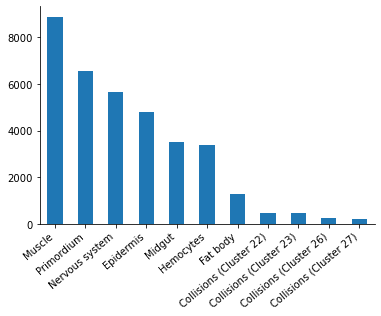

In [20]:
ax = annotation['annotation'].value_counts().plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
sns.despine()

Add indicator variables for downstream processing.

In [21]:
adata.obs['annotation'] = annotation['annotation']
adata.obs['lineage_muscle'] = adata.obs['annotation'] == 'Muscle'
adata.obs['lineage_nervous'] = (adata.obs['annotation'] == 'Nervous system') & (adata.obs['leiden_vae'] != '14')

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'annotation' as categorical


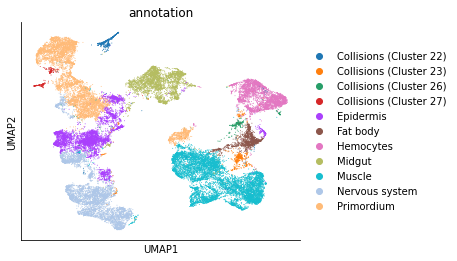

In [22]:
fig, ax = plt.subplots(figsize=(5, 4))
sc.pl.umap(adata, color=['annotation'], ax=ax, show=False)
sns.despine()

Filter putative collision clusters and save filtered anndata.

In [23]:
adata = adata[~adata.obs['annotation'].str.contains('Collisions'), :]
adata.shape

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(34053, 25000)

In [24]:
adata.write(os.path.join(settings.DATA_DIR, OUT_DIR, 'total_counts_vae_processed.h5ad'))